# CNN for 0-5 Digit Signs

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import tensorflow.keras.layers as tfl

%matplotlib inline

np.random.seed(1)

### The Sequential API
<ul>
<li>Sequential layers are <i>ordered</i></li>
<li><code>add</code> method : adds layers</li>
<li><code>pop</code> method : removes layers</li>
<li>Only single input, output handled (so, not as flexible as the Functional API)</li>
</ul>

### The Functional API
<ul>
<li>The Functional API can handle models with non-linear topology, multiple inputs and outputs (more flexible than the Sequential API)</li>
<li>Both the Sequential and Functional APIs return a TF Keras model object</li>
</ul>

In [3]:
def signs_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = signs_dataset()
print('classes', classes)

X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

classes [0 1 2 3 4 5]


In [4]:
def convolutional_model(input_shape):

    input_img = tf.keras.Input(shape=input_shape)

    Z1 = tf.keras.layers.Conv2D(filters=8 , kernel_size=(4,4) , padding='same')(input_img)
    A1 = tf.keras.layers.ReLU()(Z1)     # element-wise ReLU
    P1 = tf.keras.layers.MaxPool2D(pool_size=(8,8), strides=(8,8), padding='same')(A1)
    Z2 = tf.keras.layers.Conv2D(filters=16 , kernel_size=(2,2), strides=(1,1) , padding='same')(P1)
    A2 = tf.keras.layers.ReLU()(Z2)
    P2 = tf.keras.layers.MaxPool2D(pool_size=(4,4), strides=(4,4), padding='same')(A2)
    F = tf.keras.layers.Flatten()(P2)
    outputs = tf.keras.layers.Dense(units=6 , activation='softmax')(F)

    return tf.keras.Model(inputs=input_img, outputs=outputs)        # model

In [5]:
conv_model = convolutional_model((64, 64, 3))
# more than 2 classes, hence using "categorical" crossentropy
# metrics for evaluation : "accuracy"
conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 8)         392       
                                                                 
 re_lu (ReLU)                (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          528       
                                                                 
 re_lu_1 (ReLU)              (None, 8, 8, 16)          0         
                                                             

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)

history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 [==============================] - 1s 43ms/step - loss: 1.8328 - accuracy: 0.1583 - val_loss: 1.7893 - val_accuracy: 0.1583
Epoch 2/100
17/17 [==============================] - 1s 40ms/step - loss: 1.7930 - accuracy: 0.1407 - val_loss: 1.7840 - val_accuracy: 0.1917
Epoch 3/100
17/17 [==============================] - 1s 39ms/step - loss: 1.7872 - accuracy: 0.1870 - val_loss: 1.7810 - val_accuracy: 0.2167
Epoch 4/100
17/17 [==============================] - 1s 38ms/step - loss: 1.7830 - accuracy: 0.2130 - val_loss: 1.7760 - val_accuracy: 0.2250
Epoch 5/100
17/17 [==============================] - 1s 37ms/step - loss: 1.7787 - accuracy: 0.2398 - val_loss: 1.7711 - val_accuracy: 0.2583
Epoch 6/100
17/17 [==============================] - 1s 37ms/step - loss: 1.7737 - accuracy: 0.2722 - val_loss: 1.7649 - val_accuracy: 0.3417
Epoch 7/100
17/17 [==============================] - 1s 36ms/step - loss: 1.7679 - accuracy: 0.3065 - val_loss: 1.7564 - val_accuracy: 0.3333
Epoch 

In [7]:
print (history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


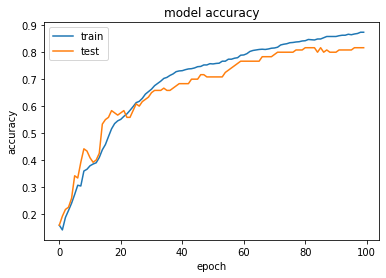

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

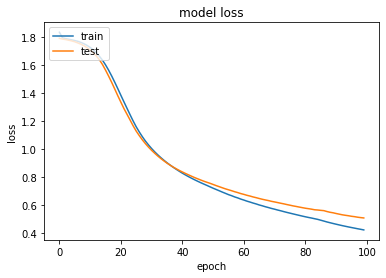

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
conv_model.evaluate(X_test,Y_test)

4/4 [==============================] - 0s 11ms/step - loss: 0.5082 - accuracy: 0.8167


[0.508169412612915, 0.8166666626930237]

In [11]:
y_pred = conv_model.predict(X_test)
y_classes = [np.argmax(element) for element in y_pred]      # ~ softmax...
# print(y_classes)

In [12]:
def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(y_classes[index])

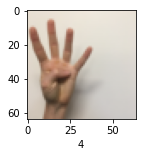

In [13]:
# Example
plot_sample(X_test, Y_test, 21)